# Data and module import

In [ ]:
import pandas as pd; import numpy as np; import pymc as pm; from scipy import stats; import arviz as az

In [ ]:
#Accidents after June 2008
data = pd.read_csv("https://raw.githubusercontent.com/javmencia/STA303/main/cyclingData.csv")

## Data cleaning

In [ ]:
def TimeGetter(time):
    ftr = [3600,60,1]
    t = sum([a*b for a,b in zip(ftr, map(int,time.split(':')))])
    if t<6*3600 or t>22*3600:
        return "Night"
    elif t<9*3600:
        return "Morning"
    elif t<14*3600:
        return "Midday"
    elif t<18*3600:
        return "Afternoon"
    else:
        return "Evening"

In [ ]:
# Missing data
# Substitute missing data with NA
data = data.replace({'Missing Data': np.NAN, 'Other': np.NAN, 'Unknown': np.NAN, 'Missing data': np.NAN})
# Assume data is missing completely at random and remove
data = data.dropna()
#data["Road_conditions"].unique()

# Data wrangling
# Day to weekday(1) and weekend(0)
data = data.replace({'Monday':1, 'Tuesday':1, 'Wednesday':1, 'Thursday':1, 'Friday': 1, 'Saturday':0, 'Sunday': 0})
# TimeDay variable, categorical

data["TimeDay"] = [TimeGetter(i) for i in data["Time"]]
# Road conditions: Dry or not
data["DryRoad"] = [1 if i=="Dry" else 0 for i in data["Road_conditions"]]

# Weather: Clear or not
data["Clear"] = [1 if i=="Clear" else 0 for i in data["Weather_conditions"]]

# Light conditions: Dark or not
data["Dark"] = [1 if i=="Darkness no lights" else 0 for i in data["Light_conditions"]]
print(data['Light_conditions'].unique())
# Road type: Binary whether it is Dual carriageway, use EDA to justify
data["DualCarriageway"] = [1 if i=="Dual carriageway" else 0 for i in data["Road_type"]]
# Age: over 55
data["over55"] = [1 if i in ["56 to 65", "66 to 75"] else 0 for i in data["Age_Grp"]]

# Severity_binary: Severe or not
data["Severity_binary"] = [0 if i=="Slight" else 1 for i in data["Severity"]]

# Night binary
data["Night"] = [1 if i=="Night" else 0 for i in data["TimeDay"]]
# Morning binary
data["Morning"] = [1 if i=="Morning" else 0 for i in data["TimeDay"]]
# Midday binary
data["Midday"] = [1 if i=="Midday" else 0 for i in data["TimeDay"]]
# Afternoon binary
data["Afternoon"] = [1 if i=="Afternoon" else 0 for i in data["TimeDay"]]
# Evening binary
data["Evening"] = [1 if i=="Evening" else 0 for i in data["TimeDay"]]
data['Gender']= [1 if i=="Male" else 0 for i in data["Gender"]]

cleandata = data[["Severity_binary", "Day", "Speed_limit", "DryRoad", "Clear", "Gender", "over55", "DualCarriageway", "TimeDay", "Night", "Morning", "Midday", "Afternoon", "Evening", "Dark"]]
cleandata.head(10)


['Darkness lights lit' 'Daylight' 'Darkness no lights']


,Severity_binary,Day,Speed_limit,DryRoad,Clear,Gender,over55,DualCarriageway,TimeDay,Night,Morning,Midday,Afternoon,Evening,Dark
0,0,1,30,1,1,1,0,0,Evening,0,0,0,0,1,0
1,0,1,30,1,1,1,0,0,Evening,0,0,0,0,1,0
2,0,1,30,1,1,1,0,0,Evening,0,0,0,0,1,0
3,0,0,30,1,1,1,0,0,Midday,0,0,1,0,0,0
4,0,1,30,1,1,1,0,0,Evening,0,0,0,0,1,0
5,0,1,30,1,1,0,1,0,Evening,0,0,0,0,1,0
6,0,1,30,1,1,0,0,0,Afternoon,0,0,0,1,0,0
7,0,1,30,1,1,0,0,0,Afternoon,0,0,0,1,0,0
8,0,1,30,1,1,1,0,0,Midday,0,0,1,0,0,0
9,1,1,30,1,1,0,0,0,Afternoon,0,0,0,1,0,0


In [ ]:
len(cleandata)

173453

In [ ]:
subset = cleandata[-100:]

x1 = subset['DryRoad']
x1 = pd.Series(x1).array

x2 = subset['Clear']
x2 = pd.Series(x2).array

x3 = subset['DualCarriageway']
x3 = pd.Series(x3).array

x4 = subset['Dark']
x4 = pd.Series(x4).array

x5 = subset['Speed_limit']
x5 = pd.Series(x5).array

x6 = subset["Night"]
x6 = pd.Series(x6).array

x7 = subset["Morning"]
x7 = pd.Series(x7).array

x8 = subset["Midday"]
x8 = pd.Series(x8).array

x9 = subset["Afternoon"]
x9 = pd.Series(x9).array

x10 = subset["Evening"]
x10 = pd.Series(x10).array

y = subset['Severity_binary']
y = pd.Series(y).array

num_obs = len(y)

# We want model with three predictors: When, What, Who

# Hierarchical structure on Time/Day betas

In [ ]:
with pm.Model() as timeday_model:
    # pWeekdayday Probability of being a weekday
    pWeekday = pm.Beta('pWeekday', alpha=1, beta=1)

    # Time weekday probabilities
    pNight = pm.Beta('pNight', alpha=1, beta=1)
    pMorningBase = pm.Beta('pMorningBase', alpha=1, beta=1)
    pMiddayBase = pm.Beta('pMiddayBase', alpha=1, beta=1)
    pAfternoonBase = pm.Beta('pAfternoonBase', alpha=1, beta=1)
    pEvening = pm.Beta('pEvening', alpha=1, beta=1)

    # Time weekend probabilities
    pMorChange = pm.Beta('pMorChange', alpha=1, beta=1)
    pMidChange = pm.Beta('pMidChange', alpha=1, beta=1)
    pAftChange = pm.Beta('pAftChange', alpha=1, beta=1)


    # pMorningBase + pWeekday*(1-pMorningBase)*pMorChange
    no_negatives_2 = pm.math.switch(pm.math.lt(pMorningBase + pWeekday * (1 - pMorningBase) * pMorChange, 0), 0,
                                     pMorningBase + pWeekday * (1 - pMorningBase) * pMorChange)
    in_unit_interval_2 = pm.math.switch(pm.math.gt(no_negatives_2, 1), 1,
                                        pMorningBase + pWeekday * (1 - pMorningBase) * pMorChange)
    pMorning = pm.Deterministic('pMorning', in_unit_interval_2)

    # pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange
    no_negatives_3 = pm.math.switch(pm.math.lt(pMiddayBase - pWeekday * (1 - pMiddayBase) * pMidChange, 0), 0,
                                     pMiddayBase - pWeekday * (1 - pMiddayBase) * pMidChange)
    in_unit_interval_3 = pm.math.switch(pm.math.gt(no_negatives_3, 1), 1,
                                        pMiddayBase - pWeekday * (1 - pMiddayBase) * pMidChange)
    pMidday = pm.Deterministic('pMidday', in_unit_interval_3)

    # pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange
    no_negatives_4 = pm.math.switch(pm.math.lt(pAfternoonBase + pWeekday * (1 - pAfternoonBase) * pAftChange, 0), 0,
                                     pAfternoonBase + pWeekday * (1 - pAfternoonBase) * pAftChange)
    in_unit_interval_4 = pm.math.switch(pm.math.gt(no_negatives_4, 1), 1,
                                        pAfternoonBase + pWeekday * (1 - pAfternoonBase) * pAftChange)
    pAfternoon = pm.Deterministic('pAfternoon', in_unit_interval_4)

    # Linear combination of predictors
    logit_p = pNight * x6 + pMorning * x7 + pMidday * x8 + pAfternoon * x9 + pEvening * x10
    logit_p = pm.Deterministic('logit_p', logit_p)

    y = pm.Bernoulli('y', logit_p=logit_p, observed=y)
    timedaydata = pm.sample()

KeyboardInterrupt: 

In [ ]:
pm.model_to_graphviz(timeday_model)

# Posterior inference Part 1

In [ ]:
print("number of MCMC samples:", timedaydata.posterior['pWeekday'].values.flatten().shape[-1])
az.summary(timedaydata, round_to=2)

NameError: name 'timedaydata' is not defined

In [ ]:
az.plot_trace(timedaydata, combined = True,var_names ='pEvening' );

Variable selection for the conditions factors using Spike and Slab

In [ ]:
predictors = ['DryRoad', 'Dark', 'DualCarriageway', 'Clear','Speed_limit']

# Get predictors and target variable as numpy arrays
X = cleandata[predictors].values[-100:]
y = cleandata['Severity_binary'].values[-100:]

# Number of predictors
n_predictors = X.shape[1]

# Define Bayesian binary regression model with spike-and-slab priors for variable selection
with pm.Model() as model:
    # Coefficients for predictors
    slab = pm.Normal('slab', mu=0, sigma=1, shape=n_predictors)

    # Indicator variables for spike-and-slab
    spike = pm.Bernoulli('spike', p=0.5, shape=n_predictors)

    # Create deterministic variable for selected coefficients
    beta = pm.Deterministic('beta', slab * spike)

    # Logistic regression model
    p = pm.math.invlogit(pm.math.dot(X, beta))
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
    idata = pm.sample()

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=False)

# Extract selected predictors based on posterior samples of gamma
selected_predictors = np.array(predictors)[np.mean(trace['spike'], axis=0) > 0.5]
print("Selected predictors:", selected_predictors)

Selected predictors: ['Dark' 'Clear']


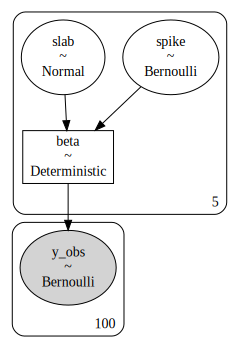

In [ ]:
pm.model_to_graphviz(model)

[Text(1, 0, 'DryRoad'),
 Text(2, 0, 'Dark'),
 Text(3, 0, 'DualCarriageway'),
 Text(4, 0, 'Clear'),
 Text(5, 0, 'Speed_limit')]

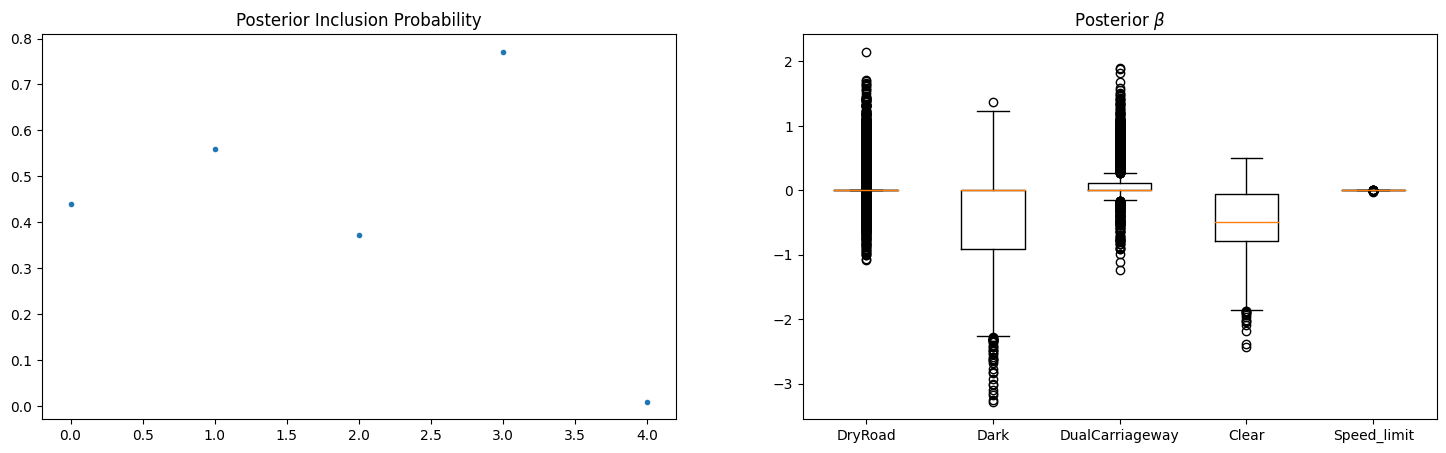

In [ ]:
# Spike and Slab variable selection plots: only the second and the fourth betas have inclusion probability > 0.5
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(18,5));

num_of_beta = 5
ax[0].plot(idata.posterior['spike'].values.reshape((-1,num_of_beta)).mean(axis=0),'.');
ax[0].set_title('Posterior Inclusion Probability');
ax[1].boxplot(idata.posterior['beta'].values.reshape((-1,num_of_beta)));
ax[1].set_title('Posterior $\\beta$');
ax[1].set_xticklabels(['DryRoad', 'Dark', 'DualCarriageway', 'Clear','Speed_limit'])

In the plot above we see that DryRoad and DualCarriageway were both not selected and they were slabbed to zero

# Combine selected predictors with hierarchical model established earlier

In [ ]:
with pm.Model() as complete_model:

    # pWeekday Probablity of being a weekday
    pWeekday = pm.Beta('pWeekday', alpha=1, beta=1)

    # Time weekday probabilities
    pNight= pm.Beta('pNight', alpha=1, beta=1) ## = p1
    pMorningBase= pm.Beta('pMorningBase', alpha=1, beta=1)
    pMiddayBase= pm.Beta('pMiddayBase', alpha=1, beta=1)
    pAfternoonBase= pm.Beta('pAfternoonBase', alpha=1, beta=1)
    pEvening= pm.Beta('pEvening', alpha=1, beta=1) ## = p5
    # Time weekend probabilities
    pMorChange= pm.Beta('pMorChange', alpha=1, beta=1)
    pMidChange= pm.Beta('pMidChange', alpha=1, beta=1)
    pAftChange= pm.Beta('pAftChange', alpha=1, beta=1)

    # pMorningBase + pWeekday*(1-pMorningBase)*pMorChange
    no_negatives_2 = pm.math.switch(pm.math.lt(pMorningBase + pWeekday*(1-pMorningBase)*pMorChange,0), 0, pMorningBase + pWeekday*(1-pMorningBase)*pMorChange)
    in_unit_interval_2 = pm.math.switch(pm.math.gt(no_negatives_2,1), 1, pMorningBase + pWeekday*(1-pMorningBase)*pMorChange)
    pMorning = pm.Deterministic('pMorning', in_unit_interval_2)

    # pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange
    no_negatives_3 = pm.math.switch(pm.math.lt(pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange,0), 0, pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange)
    in_unit_interval_3 = pm.math.switch(pm.math.gt(no_negatives_3,1), 1, pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange)
    pMidday = pm.Deterministic('pMidday', in_unit_interval_3)

    # pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange
    no_negatives_4 = pm.math.switch(pm.math.lt(pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange,0), 0, pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange)
    in_unit_interval_4 = pm.math.switch(pm.math.gt(no_negatives_4,1), 1, pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange)
    pAfternoon = pm.Deterministic('pAfternoon', in_unit_interval_4)

    # Intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Priors of selected condition predictors
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Linear combination of predictors
    logit_p = intercept + pNight*x6 +pMorning*x7 +pMidday*x8 +pAfternoon*x9 +pEvening*x10 + beta_clear*x2 + beta_dark*x4
    logit_p = pm.Deterministic('logit_p',logit_p)

    Y = pm.Bernoulli('Y', logit_p = logit_p, observed=y)

    idata_2 = pm.sample()

In [ ]:
print("number of MCMC samples:", idata_2.posterior['pWeekday'].values.flatten().shape[-1])
az.summary(idata_2, round_to=2)

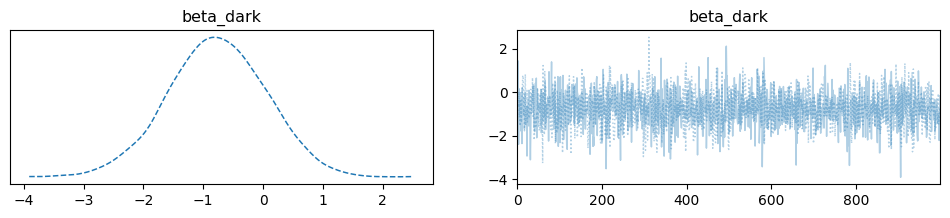

In [ ]:
az.plot_trace(idata_2, combined = True,var_names ='beta_dark' );

# Model diagnostic Part I

In [ ]:
# Baisc regression model for comparison
with pm.Model() as model_basic:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=1)
    beta_4 = pm.Normal('beta_4', mu=0, sigma=1)
    beta_5 = pm.Normal('beta_5', mu=0, sigma=1)
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Linear combination of predictors
    logit_p = beta_0 + beta_1*x6 +beta_2*x7 +beta_3*x8 +beta_4*x9 +beta_5*x10 + beta_clear*x2 + beta_dark*x4
    logit_p = pm.Deterministic('logit_p',logit_p)

    Basic_Y = pm.Bernoulli('Basic_Y', logit_p = logit_p, observed=y)

    idata_3 = pm.sample()

In [ ]:
with complete_model:
    trace_complete = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_complete) # or pass `idata_kwargs={"log_likelihood": True}` to `pm.sample`

with model_basic:
    trace_basic = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_basic)

In [ ]:
az.waic(trace_complete)

<ipython-input-55-dbc902779305>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(trace_complete)


Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -67.58     2.58
p_waic        2.69        -

In [ ]:
az.waic(trace_basic)

<ipython-input-56-ccd65360a166>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(trace_basic)


Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -68.86     2.93
p_waic        4.43        -

In [ ]:
az.compare({"complete model": trace_complete, "basic model": trace_basic}, ic='waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
complete model,0,-67.584635,2.686720,0.000000,1.0,2.577915,0.000000,False,log
basic model,1,-68.863992,4.430821,1.279357,0.0,2.930239,0.896984,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

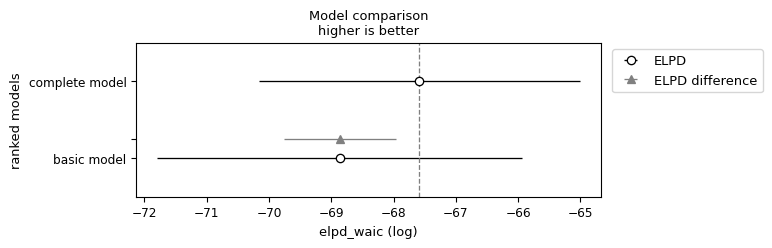

In [ ]:
az.plot_compare(az.compare({ "complete model": trace_complete, "basic model": trace_basic}, ic='waic'), insample_dev=False)

# Mixture model

In [ ]:
subset = cleandata[-100:]

x1 = subset['DryRoad']
x1 = pd.Series(x1).array

x2 = subset['Clear']
x2 = pd.Series(x2).array

x3 = subset['DualCarriageway']
x3 = pd.Series(x3).array

x4 = subset['Dark']
x4 = pd.Series(x4).array

x5 = subset['Speed_limit']
x5 = pd.Series(x5).array

x6 = subset["Night"]
x6 = pd.Series(x6).array

x7 = subset["Morning"]
x7 = pd.Series(x7).array

x8 = subset["Midday"]
x8 = pd.Series(x8).array

x9 = subset["Afternoon"]
x9 = pd.Series(x9).array

x10 = subset["Evening"]
x10 = pd.Series(x10).array

xover55 = subset["over55"]
xover55 = pd.Series(subset["over55"]).array
xGender = pd.Series(subset["Gender"]).array

y = subset['Severity_binary']
y = pd.Series(y).array

num_obs = len(y)

In [ ]:
# Define the mixture model
with pm.Model() as mixture_model:
    # Define mixture component for Gender
    alpha_gender = pm.Normal('alpha_gender', mu=0, sigma=1)
    beta_gender = pm.Normal('beta_gender', mu=0, sigma=1)
    mixture_gender = pm.Bernoulli('mixture_gender', p=0.5)  # Prior probability of being in each component

    # Define mixture component for over55
    alpha_over55 = pm.Normal('alpha_over55', mu=0, sigma=1)
    beta_over55 = pm.Normal('beta_over55', mu=0, sigma=1)
    mixture_over55 = pm.Bernoulli('mixture_over55', p=0.5)  # Prior probability of being in each component

    # pWeekday Probablity of being a weekday
    pWeekday = pm.Beta('pWeekday', alpha=1, beta=1)

    # Time weekday probabilities
    pNight= pm.Beta('pNight', alpha=1, beta=1) ## = p1
    pMorningBase= pm.Beta('pMorningBase', alpha=1, beta=1)
    pMiddayBase= pm.Beta('pMiddayBase', alpha=1, beta=1)
    pAfternoonBase= pm.Beta('pAfternoonBase', alpha=1, beta=1)
    pEvening= pm.Beta('pEvening', alpha=1, beta=1) ## = p5
    # Time weekend probabilities
    pMorChange= pm.Beta('pMorChange', alpha=1, beta=1)
    pMidChange= pm.Beta('pMidChange', alpha=1, beta=1)
    pAftChange= pm.Beta('pAftChange', alpha=1, beta=1)

    # pMorningBase + pWeekday*(1-pMorningBase)*pMorChange
    no_negatives_2 = pm.math.switch(pm.math.lt(pMorningBase + pWeekday*(1-pMorningBase)*pMorChange,0), 0, pMorningBase + pWeekday*(1-pMorningBase)*pMorChange)
    in_unit_interval_2 = pm.math.switch(pm.math.gt(no_negatives_2,1), 1, pMorningBase + pWeekday*(1-pMorningBase)*pMorChange)
    pMorning = pm.Deterministic('pMorning', in_unit_interval_2)

    # pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange
    no_negatives_3 = pm.math.switch(pm.math.lt(pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange,0), 0, pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange)
    in_unit_interval_3 = pm.math.switch(pm.math.gt(no_negatives_3,1), 1, pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange)
    pMidday = pm.Deterministic('pMidday', in_unit_interval_3)

    # pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange
    no_negatives_4 = pm.math.switch(pm.math.lt(pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange,0), 0, pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange)
    in_unit_interval_4 = pm.math.switch(pm.math.gt(no_negatives_4,1), 1, pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange)
    pAfternoon = pm.Deterministic('pAfternoon', in_unit_interval_4)

    # Intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Priors of selected condition predictors
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Combine mixture components with the existing linear combination
    logit_p = intercept + pNight*x6 + pMorning*x7 + pMidday*x8 + pAfternoon*x9 + pEvening*x10 + beta_clear*x2 + beta_dark*x4 \
    + mixture_gender * (alpha_gender + beta_gender * xGender) + mixture_over55 * (alpha_over55 + beta_over55 * xover55)
    logit_p = pm.Deterministic('logit_p',logit_p)

    # Define likelihood
    Y = pm.Bernoulli('Y', logit_p=logit_p, observed=y)

    # Sample from the model
    idata_4 = pm.sample()


In [ ]:
with pm.Model() as mixture_model:
    # Define mixture component for Gender
    alpha_gender_0 = pm.Normal('alpha_gender_0', mu=0, sigma=1)
    beta_gender_0 = pm.Normal('beta_gender_0', mu=0, sigma=1)

    alpha_gender_1 = pm.Normal('alpha_gender_1', mu=0, sigma=1)
    beta_gender_1 = pm.Normal('beta_gender_1', mu=0, sigma=1)

    # Mixture component for Gender
    mixture_gender = pm.Bernoulli('mixture_gender', p=0.5)  # Prior probability of belonging to each component

    # Define mixture component for over55
    alpha_over55_0 = pm.Normal('alpha_over55_0', mu=0, sigma=1)
    beta_over55_0 = pm.Normal('beta_over55_0', mu=0, sigma=1)

    alpha_over55_1 = pm.Normal('alpha_over55_1', mu=0, sigma=1)
    beta_over55_1 = pm.Normal('beta_over55_1', mu=0, sigma=1)

    # Mixture component for over55
    mixture_over55 = pm.Bernoulli('mixture_over55', p=0.5)  # Prior probability of belonging to each component

    # Define mixture probabilities
    mixture_prob_gender = pm.math.switch(mixture_gender, 1, 0)
    mixture_prob_over55 = pm.math.switch(mixture_over55, 1, 0)

    # pWeekday Probablity of being a weekday
    pWeekday = pm.Beta('pWeekday', alpha=1, beta=1)

    # Time weekday probabilities
    pNight= pm.Beta('pNight', alpha=1, beta=1) ## = p1
    pMorningBase= pm.Beta('pMorningBase', alpha=1, beta=1)
    pMiddayBase= pm.Beta('pMiddayBase', alpha=1, beta=1)
    pAfternoonBase= pm.Beta('pAfternoonBase', alpha=1, beta=1)
    pEvening= pm.Beta('pEvening', alpha=1, beta=1) ## = p5
    # Time weekend probabilities
    pMorChange= pm.Beta('pMorChange', alpha=1, beta=1)
    pMidChange= pm.Beta('pMidChange', alpha=1, beta=1)
    pAftChange= pm.Beta('pAftChange', alpha=1, beta=1)

    # pMorningBase + pWeekday*(1-pMorningBase)*pMorChange
    no_negatives_2 = pm.math.switch(pm.math.lt(pMorningBase + pWeekday*(1-pMorningBase)*pMorChange,0), 0, pMorningBase + pWeekday*(1-pMorningBase)*pMorChange)
    in_unit_interval_2 = pm.math.switch(pm.math.gt(no_negatives_2,1), 1, pMorningBase + pWeekday*(1-pMorningBase)*pMorChange)
    pMorning = pm.Deterministic('pMorning', in_unit_interval_2)

    # pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange
    no_negatives_3 = pm.math.switch(pm.math.lt(pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange,0), 0, pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange)
    in_unit_interval_3 = pm.math.switch(pm.math.gt(no_negatives_3,1), 1, pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange)
    pMidday = pm.Deterministic('pMidday', in_unit_interval_3)

    # pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange
    no_negatives_4 = pm.math.switch(pm.math.lt(pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange,0), 0, pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange)
    in_unit_interval_4 = pm.math.switch(pm.math.gt(no_negatives_4,1), 1, pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange)
    pAfternoon = pm.Deterministic('pAfternoon', in_unit_interval_4)

    # Intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Priors of selected condition predictors
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Combine mixture components with the existing linear combination
    logit_p = intercept + pNight * x6 + pMorning * x7 + pMidday * x8 + pAfternoon * x9 + pEvening * x10 + beta_clear * x2 + beta_dark * x4 \
              + mixture_prob_gender * (pm.math.switch(mixture_gender, alpha_gender_1 + beta_gender_1 * xGender, alpha_gender_0 + beta_gender_0 * xGender)) \
              + mixture_prob_over55 * (pm.math.switch(mixture_over55,alpha_over55_1 + beta_over55_1 * xover55,alpha_over55_0 + beta_over55_0 * xover55))
    logit_p = pm.Deterministic('logit_p',logit_p)

    # Define likelihood
    Y = pm.Bernoulli('Y', logit_p=logit_p, observed=y)

    # Sample from the model
    idata_4 = pm.sample()


In [ ]:
print("number of MCMC samples:", idata_4.posterior['pWeekday'].values.flatten().shape[-1])
az.summary(idata_4, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_gender_0,-0.01,1.01,-1.94,1.79,0.03,0.03,1445.57,1241.64,1.00
beta_gender_0,-0.04,1.01,-1.81,1.89,0.02,0.03,1715.58,1284.39,1.00
alpha_gender_1,-0.20,0.97,-2.00,1.58,0.03,0.03,1379.83,1137.12,1.00
beta_gender_1,0.03,0.88,-1.64,1.75,0.02,0.02,2450.84,1399.90,1.00
mixture_gender,0.36,0.48,0.00,1.00,0.03,0.02,299.21,299.21,1.01
...,...,...,...,...,...,...,...,...,...
logit_p[95],-0.43,0.26,-0.92,0.07,0.01,0.00,1811.80,1575.27,1.00
logit_p[96],-0.50,0.40,-1.29,0.18,0.01,0.01,1346.97,1339.11,1.00
logit_p[97],-0.70,0.36,-1.33,0.01,0.01,0.01,1654.32,1510.76,1.00
logit_p[98],-0.65,0.36,-1.32,0.02,0.01,0.01,1568.66,1234.80,1.00


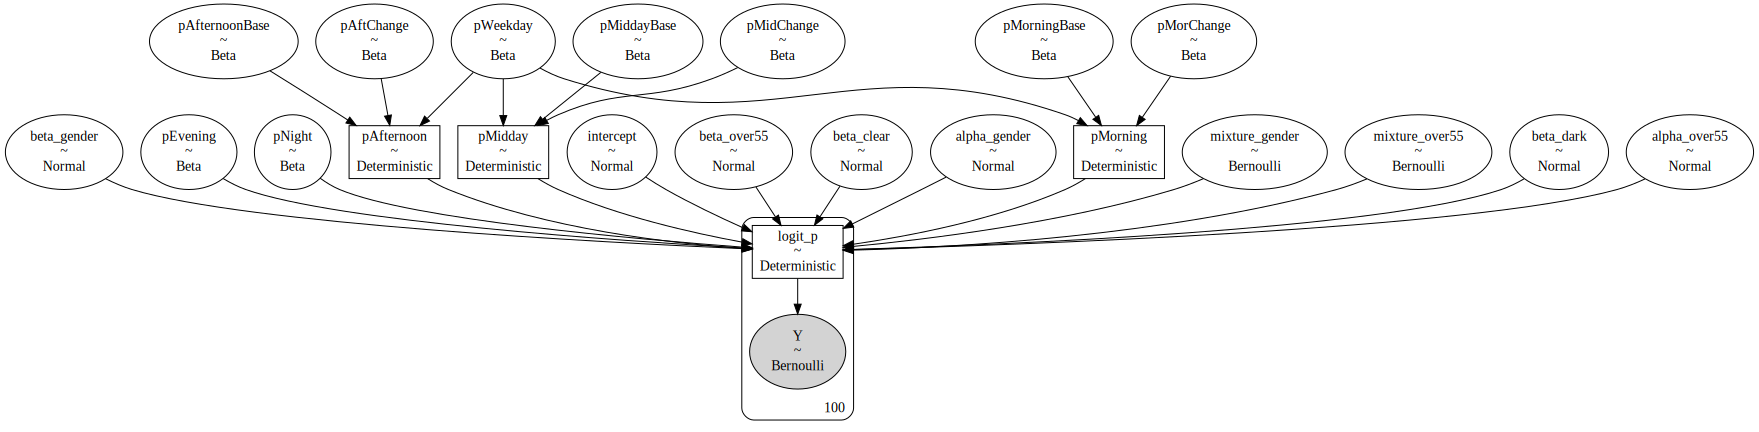

In [ ]:
pm.model_to_graphviz(mixture_model)

In [ ]:
az.plot_trace(idata_4, var_names=['alpha_gender_1', 'alpha_gender_0'], combined=True) #alpha_over55_1, beta_over55_1, alpha_over55_0, beta_over55_0, alpha_gender_1,alpha_gender_0, beta_gender_0, beta_gender_1, mixture_gender, gender_component

KeyError: 'var names: "[\'mixture_prob_gender\'] are not present" in dataset'

# Model diagnostic Part II



In [ ]:
# Baisc regression model for comparison
with pm.Model() as model_basic:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=1)
    beta_4 = pm.Normal('beta_4', mu=0, sigma=1)
    beta_5 = pm.Normal('beta_5', mu=0, sigma=1)
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Linear combination of predictors
    logit_p = beta_0 + beta_1*x6 +beta_2*x7 +beta_3*x8 +beta_4*x9 +beta_5*x10 + beta_clear*x2 + beta_dark*x4
    logit_p = pm.Deterministic('logit_p',logit_p)

    Basic_Y = pm.Bernoulli('Basic_Y', logit_p = logit_p, observed=y)

    idata_3 = pm.sample()

In [ ]:
with mixture_model:
    trace_mix = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_mix)

with complete_model:
    trace_complete = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_complete)

with model_basic:
    trace_basic = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_basic)


In [ ]:
az.waic(trace_mix)

<ipython-input-31-6b3c8ef858ff>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(trace_mix)


Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -68.09     2.61
p_waic        3.45        -

In [ ]:
az.compare({"mixture model": trace_mix, "complete model": trace_complete, "basic model": trace_basic}, ic='waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
complete model,0,-67.909483,3.305238,0.000000,1.000000e+00,2.632463,0.000000,False,log
mixture model,1,-68.088793,3.451801,0.179310,1.665335e-16,2.607530,0.056638,False,log
basic model,2,-68.862010,4.436346,0.952526,2.220446e-16,2.938695,0.926607,False,log


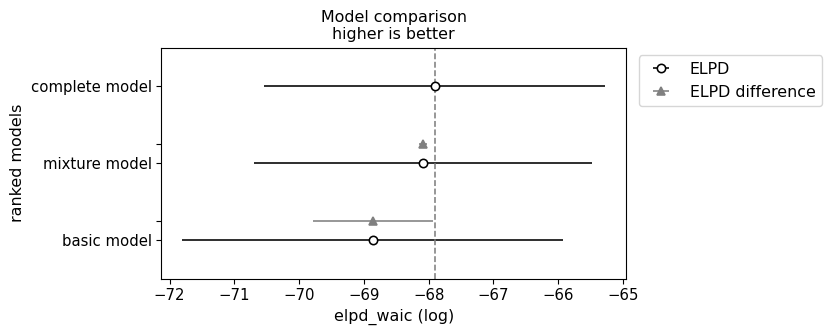

In [ ]:
az.plot_compare(az.compare({"mixture model": trace_mix, "complete model": trace_complete, "basic model": trace_basic}, ic='waic'), insample_dev=False);